In [15]:
import pandas as pd
import plotly.graph_objects as go

import plotly.express as px

cols = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"]
car_data = pd.read_csv("car.data", header=None, names=cols)

labels = ["Nieakceptolwany", "Akceptowalny", "Dobry", "Bardzo Dobry"]
class_counts = car_data["class"].value_counts()

print(class_counts)
fig = px.pie(
    names=labels,
    values=class_counts,
    title='Przykładowy wykres kołowy',
)

fig.update_traces(textinfo='percent', textposition='inside')

fig.show()

class
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64


In [16]:
filtered = car_data[car_data["doors"].isin(["2", "3", "4"])]

df = filtered.groupby(["safety", "doors"]).size().reset_index(name="count")

df["safety"] = df["safety"].replace({
    "low": "Niska",
    "med": "Średnia",
    "high": "Wysoka"
})

fig = px.bar(
    df,
    x="safety",
    y="count",
    color="doors",
    barmode="group", 
    title="Liczba samochodów 2-, 3- i 4-drzwiowych w różnych klasach bezpieczeństwa",
    labels={
        "safety": "Klasa bezpieczeństwa",
        "count": "Liczba samochodów",
        "doors": "Liczba drzwi",
    }
)
fig.show()

In [17]:
car_data["buying_num"] = car_data["buying"].replace({
    "low": 1,
    "med": 3,
    "high": 7,
    "vhigh": 10
})

car_data["maint_num"] = car_data["maint"].replace({
    "low": 1,
    "med": 3,
    "high": 7,
    "vhigh": 10
})

car_data["doors_num"] = car_data["doors"].replace({
    "2": 2,
    "3": 3,
    "4": 4,
    "5more": 5
})


car_data["persons_num"] = car_data["persons"].replace({
    "2": 2,
    "4": 4,
    "more": 5
})


car_data["safety_num"] = car_data["safety"].replace({
    "low": 1,
    "med": 5,
    "high": 10
})


avg_values = car_data[["buying_num", "maint_num", "doors_num", "persons_num", "safety_num"]].mean()

df_radar = pd.DataFrame({
    "Cecha": ["buying", "maint", "doors", "persons", "safety"],
    "Wartość": avg_values.values
})


fig_radar = px.line_polar(
    df_radar,
    r="Wartość",
    theta="Cecha",
    line_close=True,
    title="Radar cech samochodów"
)

fig_radar.update_polars(radialaxis=dict(range=[0, 10]))
fig_radar.update_traces(fill='toself')

fig_radar.show()

/var/folders/vl/g2_dzxfn18zcfpxm0wy_cl180000gn/T/ipykernel_88363/2748744601.py:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/vl/g2_dzxfn18zcfpxm0wy_cl180000gn/T/ipykernel_88363/2748744601.py:8: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/vl/g2_dzxfn18zcfpxm0wy_cl180000gn/T/ipykernel_88363/2748744601.py:15: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to

In [18]:
group_means = (
    car_data.groupby("class")[["buying_num", "maint_num", "doors_num", "persons_num", "safety_num"]]
    .mean()
    .reset_index()
)

radar_df = group_means.melt(
    id_vars="class",
    var_name="Cecha",
    value_name="Wartość"
)

radar_df = radar_df.replace({'acc': 'Akceptowalny', "good": "Dobry stan", "unacc": "Nieakceptowalny", "vgood": "Bardzo dobry stan"})

fig_radar = px.line_polar(
    radar_df,
    r="Wartość",
    theta="Cecha",
    color="class",
    line_close=True,
    title="Radar cech samochodów wg klasy (class)"
)

fig_radar.update_polars(radialaxis=dict(range=[0, 10]))
fig_radar.update_layout(legend_title_text="Klasa samochodu")
fig_radar.update_traces(fill='toself')

fig_radar.show()



In [19]:
def is_good_car(row):
    score = 0

    if row['buying_num'] <= 4:
        score += 2
    elif row['buying_num'] <= 6:
        score += 1

    if row['maint_num'] <= 4:
        score += 2
    elif row['maint_num'] <= 6:
        score += 1

    if row['persons_num'] >= 4:
        score += 2
    elif row['persons_num'] == 2:
        score -= 1

    if row['safety_num'] >= 7:
        score += 3
    elif row['safety_num'] >= 5:
        score += 2
    else:
        score -= 2

    if row['doors_num'] < 3:
        score -= 1

    return "TAK" if score >= 8 else "NIE"

car_data["is_good"] = car_data.apply(is_good_car, axis=1)

mask = car_data["class"].isin(["good", "vgood"])
accuracy = (car_data["is_good"].eq(mask.map({True: "TAK", False: "NIE"}))).mean()
print(f"Dokładność reguły: {accuracy:.2%}")

Dokładność reguły: 95.83%


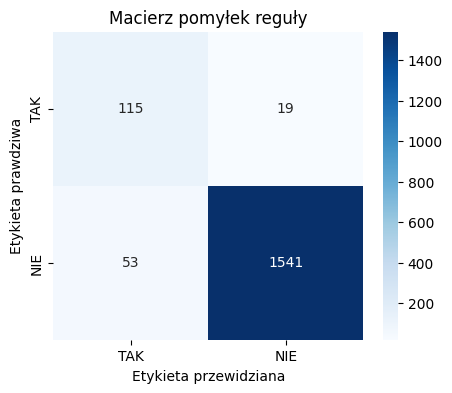

In [20]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

car_data["real_label"] = car_data["class"].isin(["good", "vgood"]).map({True: "TAK", False: "NIE"})

conf_matrix = confusion_matrix(car_data["real_label"], car_data["is_good"], labels=["TAK", "NIE"])

plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["TAK", "NIE"], yticklabels=["TAK", "NIE"])
plt.ylabel('Etykieta prawdziwa')
plt.xlabel('Etykieta przewidziana')
plt.title('Macierz pomyłek reguły')
plt.show()
